<a href="https://colab.research.google.com/github/Pranayshukla0610/ML-projects-portfolio/blob/main/Demand_Forecasting_%26_Price_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, random, joblib
from math import sqrt
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [ ]:
FILE_PATH = "/content/PS_MOM_Sales_2025_12_12.xlsb"
ARTIFACT_DIR = "/content/model_artifacts"

In [ ]:
os.makedirs(ARTIFACT_DIR, exist_ok=True)

In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [ ]:
!pip install pyxlsb

In [ ]:
print("Loading file:",FILE_PATH)
df = pd.read_excel(FILE_PATH,engine="pyxlsb")

Loading file: /content/PS_MOM_Sales_2025_12_12.xlsb


In [ ]:
print("Raw rows, cols:",df.shape)
display(df.head())

Raw rows, cols: (520469, 20)


,month_,Month,State,warehouse_name,wh_type,deal_type,sku_id,product_name,Department,MainL1,L2_name,L3_name,INC_Qty,INC_GMV,INC_Dis_Amount,INC_NBP,Del_Qty,Del_Value,Del_Dis_amount,Del_NBP
0,11,45962,WB,Kasba(SS),New_Warehouse,BAU,D35F3FD8D1,Dabur Chyawanprash With Awaleha - 950 Gm,FMCG - Food,Beverages,Honey & Chyawanprash,Chyawanprash & Other Products,30,11613.0,194,10631.10,30.0,11613.0,194,10631.10
1,11,45962,WB,Kasba(SS),New_Warehouse,BAU,42CD22761E,Dabur Chyawanprash Awaleha - 250 Gm,FMCG - Food,Beverages,Honey & Chyawanprash,Chyawanprash & Other Products,51,4590.0,153,4448.22,51.0,4590.0,153,4448.22
2,11,45962,WB,Shibpur(SS),New_Warehouse,BAU,5024FF0E94,Sampoorti Honey - 500 Gm,FMCG - Food,Beverages,Honey & Chyawanprash,Honey,117,11583.0,402,9477.00,117.0,11583.0,402,9477.00
3,11,45962,RJ,Bhankrota(SS),New_Warehouse,BAU,3328674FD7,Knorr Hot & Sour Veg Cup A Soup (flavour Commo...,FMCG - Food,Beverages,Soups,Soup,30,252.0,5,228.30,30.0,252.0,5,228.30
4,11,45962,UP,MVT Ibrahimpur(SS),New_Warehouse,BAU,42CD22761E,Dabur Chyawanprash Awaleha - 250 Gm,FMCG - Food,Beverages,Honey & Chyawanprash,Chyawanprash & Other Products,8,880.0,24,825.30,8.0,880.0,24,825.30


In [ ]:
df = df.copy()
df = df[~df['Del_Qty'].isna()]
df = df[df['Del_Qty'] > 0].reset_index(drop=True)
df['price'] = df['Del_Value']/df['Del_Qty']

In [ ]:
# Unit cost: prefer Del_NBP / Del_Qty when available, otherwise fallback to 60% of price
df['unit_cost'] = np.where((~df.get('Del_NBP',pd.Series()).isna()) & (df['Del_Qty']>0),df['Del_NBP']/df['Del_Qty'],0.6*df['price'])
df['demand'] = df['Del_Qty']

In [ ]:
# Month extraction: prefer a 'month_' column else try Excel serial in 'Month'
if 'month_' in df.columns and np.issubdtype(df['month_'].dtype,np.number):
  df['month_int'] = df['month_'].astype(int)
else:
  try:
    df['month_dt'] = pd.to_datetime(df['Month'],unit='d',origin='1899-12-30')
    df['month_int'] = df['month_dt'].dt.month
  except:
    df['month_int'] = 0

In [ ]:
cols_keep = ['month_int','sku_id','warehouse_name','wh_type','deal_type','product_name','MainL1','L2_name','L3_name','price','unit_cost','demand','INC_Qty','INC_GMV']
cols_keep = [c for c in cols_keep if c in df.columns]
df = df[cols_keep].copy()
print('After selecting cols:',df.shape)

After selecting cols: (370507, 14)


In [ ]:
# 3) PREPROCESSING & FEATURE ENGINEERING
# Categorical encoding: ensure uniform string type then LabelEncode
cat_cols = [c for c in ['sku_id','warehouse_name','wh_type','deal_type','MainL1','L2_name','L3_name']if c in df.columns]
encoders = {}

In [ ]:
for c in cat_cols:
  df[c] = df[c].fillna("NA").astype(str)
  le = LabelEncoder()
  df[c + '_enc'] = le.fit_transform(df[c])
  encoders[c] = le

In [ ]:
df.columns.tolist()

['month_int',
 'sku_id',
 'warehouse_name',
 'wh_type',
 'deal_type',
 'product_name',
 'MainL1',
 'L2_name',
 'L3_name',
 'price',
 'unit_cost',
 'demand',
 'INC_Qty',
 'INC_GMV',
 'sku_id_enc',
 'warehouse_name_enc',
 'wh_type_enc',
 'deal_type_enc',
 'MainL1_enc',
 'L2_name_enc',
 'L3_name_enc']

In [ ]:
# SKU-level aggregates: median price and mean demand per SKU (helps cold-start)
sku_agg = df.groupby('sku_id').agg({'price':'median','demand':'mean'}).rename(
    columns={'price':'sku_median_price','demand':'sku_mean_demand'})
sku_agg = sku_agg.fillna(0)
df = df.merge(sku_agg, left_on='sku_id', right_index=True, how='left')

In [ ]:
# Derived features
df['price_rel'] = df['price'] / (df['sku_median_price'] + 1e-6)
df['is_promo'] = df['deal_type'].apply(lambda x: 1 if 'promo' in str(x).lower() or 'offer' in str(x).lower() else 0)
df['log_price'] = np.log1p(df['price'])
df['log_demand'] = np.log1p(df['demand'])

In [ ]:
# Final features list (tweak as desired)
feature_cols = ['month_int','price','unit_cost','sku_median_price','sku_mean_demand','price_rel','is_promo']
feature_cols += [c + '_enc' for c in cat_cols]
feature_cols = [c for c in feature_cols if c in df.columns]
print("Feature columns:", feature_cols)

Feature columns: ['month_int', 'price', 'unit_cost', 'sku_median_price', 'sku_mean_demand', 'price_rel', 'is_promo', 'sku_id_enc', 'warehouse_name_enc', 'wh_type_enc', 'deal_type_enc', 'MainL1_enc', 'L2_name_enc', 'L3_name_enc']


In [ ]:
# 4) TRAIN/TEST SPLIT (time-based)
months_sorted = sorted(df['month_int'].unique())
print("Months found:", months_sorted)
if len(months_sorted) >= 2:
    train_months = months_sorted[:-1]
    test_month = months_sorted[-1]
    train_df = df[df['month_int'].isin(train_months)].reset_index(drop=True).copy()
    test_df = df[df['month_int']==test_month].reset_index(drop=True).copy()
else:
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)

Months found: [np.int64(9), np.int64(10), np.int64(11)]


In [ ]:
print("Train rows:", len(train_df), "Test rows:", len(test_df))

Train rows: 239623 Test rows: 130884


In [ ]:
X_train = train_df[feature_cols].copy()
y_train = train_df['demand'].copy()
X_test = test_df[feature_cols].copy()
y_test = test_df['demand'].copy()

In [ ]:
# Scale numeric features
num_cols = [c for c in ['price','unit_cost','sku_median_price','sku_mean_demand','price_rel','log_price'] if c in X_train.columns]
scaler = StandardScaler()
if len(num_cols)>0:
    X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
    X_test[num_cols] = scaler.transform(X_test[num_cols])

In [ ]:
# Save encoders & scaler
joblib.dump(encoders, os.path.join(ARTIFACT_DIR, "encoders.joblib"))
joblib.dump(scaler, os.path.join(ARTIFACT_DIR, "scaler.joblib"))

['/content/model_artifacts/scaler.joblib']

In [ ]:
dtrain = xgb.DMatrix(
    X_train,
    label=y_train,
    feature_names=list(X_train.columns)
)

dtest = xgb.DMatrix(
    X_test,
    label=y_test,
    feature_names=list(X_test.columns)
)


In [ ]:
params = {
    'objective':'reg:squarederror',
    'max_depth':6,
    'eta':0.1,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'seed':RANDOM_SEED,
    'verbosity':0
}

In [ ]:
print("Training XGBoost (may take a few minutes depending on data size)...")
model = xgb.train(params, dtrain, num_boost_round=300, evals=[(dtrain,'train'),(dtest,'eval')],
                  early_stopping_rounds=25, verbose_eval=50)

Training XGBoost (may take a few minutes depending on data size)...
[0]	train-rmse:2228.49241	eval-rmse:1256.70709
[41]	train-rmse:580.73062	eval-rmse:631.47171


In [ ]:
# Save model
model.save_model(os.path.join(ARTIFACT_DIR, "xgb_demand.model"))

In [ ]:
# Evaluate
y_pred = model.predict(dtest)
rmse = sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-6))) * 100
print(f"Demand model performance on TEST: RMSE={rmse:.3f}, MAE={mae:.3f}, MAPE={mape:.2f}%")

Demand model performance on TEST: RMSE=631.472, MAE=41.911, MAPE=325.79%


In [ ]:
# Feature importance display
fi = model.get_score(importance_type='weight')
fi = pd.DataFrame.from_dict(fi, orient='index', columns=['weight']).sort_values('weight', ascending=False)
print("Top features:")
display(fi.head(20))

Top features:


,weight
price_rel,449.0
warehouse_name_enc,342.0
sku_mean_demand,251.0
sku_id_enc,247.0
price,214.0
unit_cost,184.0
deal_type_enc,141.0
L3_name_enc,139.0
L2_name_enc,108.0
sku_median_price,90.0


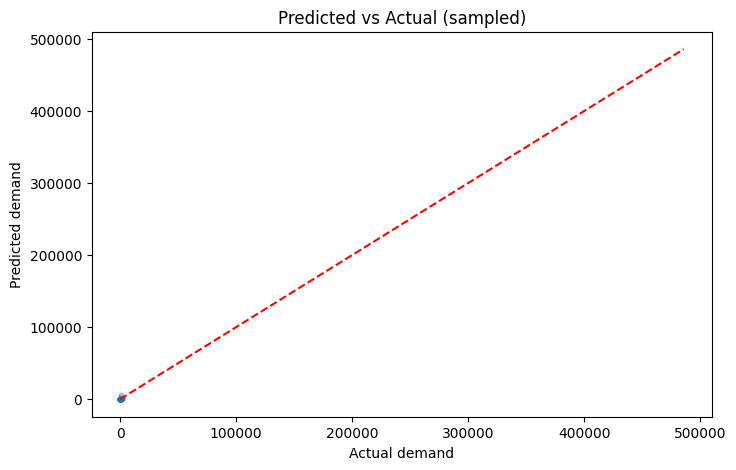

In [ ]:
# Pred vs actual plot
plt.figure(figsize=(8,5))
plt.scatter(y_test.sample(1000, random_state=RANDOM_SEED), y_pred.take(np.random.choice(len(y_pred), size=min(1000,len(y_pred)), replace=False)), alpha=0.4, s=10)
plt.plot([0, max(y_test.max(), y_pred.max())],[0, max(y_test.max(), y_pred.max())], 'r--')
plt.xlabel("Actual demand"); plt.ylabel("Predicted demand")
plt.title("Predicted vs Actual (sampled)")
plt.show()

In [ ]:
# 6) RL PRICE OPTIMIZATION (Simple Q-learning)
# Approach:
# - Discretize price grid (around sku median price)
# - Build state as (sku cluster, month_int) to keep state space manageable
# - For each step: select price action -> use XGBoost to predict demand -> reward = (price - unit_cost) * predicted_demand
# - Q-table update using one-step episodes

In [ ]:
median_price = df['price'].median()
price_grid = np.round(np.linspace(0.5*median_price, 1.5*median_price, 11), 2).tolist()
print("Price grid:", price_grid)

Price grid: [43.0, 51.6, 60.2, 68.8, 77.4, 86.0, 94.6, 103.2, 111.8, 120.4, 129.0]


In [ ]:
# Cluster SKUs (using sku_agg)
sku_agg = sku_agg.reset_index()
cluster_k = min(10, max(2, int(len(sku_agg)/50)))
cluster_k = max(2, cluster_k)
kmeans = KMeans(n_clusters=cluster_k, random_state=RANDOM_SEED)
kmeans.fit(sku_agg[['sku_median_price','sku_mean_demand']].fillna(0))
sku_agg['cluster'] = kmeans.labels_
sku_cluster_map = dict(zip(sku_agg['sku_id'], sku_agg['cluster']))

In [ ]:
df['cluster'] = df['sku_id'].map(sku_cluster_map).fillna(0).astype(int)
df['state_id'] = df['cluster'].astype(str) + "_" + df['month_int'].astype(str)
state_ids = df['state_id'].unique().tolist()
state_to_idx = {s:i for i,s in enumerate(state_ids)}
idx_to_state = {i:s for s,i in state_to_idx.items()}

In [ ]:
n_states = len(state_ids)
n_actions = len(price_grid)
print(f"Q-learning: n_states={n_states}, n_actions={n_actions}")

Q-learning: n_states=30, n_actions=11


In [ ]:
# Q-table
Q = np.zeros((n_states, n_actions))
alpha = 0.1
gamma = 0.95
epsilon = 0.2
n_episodes = 5000  # increase if you have compute/time

In [ ]:
# Precompute arrays for speed
row_state_idx = df['state_id'].map(state_to_idx).values
row_unit_cost = df['unit_cost'].values
# For mapping row index to feature vector, we'll use df and re-compute price-related features per action

In [ ]:
def predict_demand_from_features(row_series, chosen_price, model, scaler, feature_cols, X_train_columns, num_cols):
    # Convert columns to list (critical)
    X_train_columns = list(X_train_columns)

    # create feature dict
    feat = {}
    for c in feature_cols:
        if c == 'price':
            feat['price'] = chosen_price
        elif c in row_series.index:
            feat[c] = row_series[c]
        else:
            feat[c] = 0

    feat['price_rel'] = feat['price'] / (feat.get('sku_median_price',1) + 1e-6)
    feat['log_price'] = np.log1p(feat['price'])

    temp = pd.DataFrame([feat], columns=feature_cols)

    if len(num_cols) > 0:
        temp[num_cols] = scaler.transform(temp[num_cols])

    temp = temp[X_train_columns]

    # XGBoost requires feature_names as a list
    dmat = xgb.DMatrix(temp, feature_names=X_train_columns)

    pred = model.predict(dmat)[0]
    return max(0, pred)



In [ ]:
# Q-Learning loop (one-step episodes)
print("Starting Q-learning (this may take a few minutes depending on n_episodes and data size)...")
for ep in range(n_episodes):
    # sample a random row index
    i = random.randrange(len(df))
    s = int(row_state_idx[i])
    # choose action
    if random.random() < epsilon:
        a = random.randrange(n_actions)
    else:
        a = int(Q[s].argmax())
    chosen_price = price_grid[a]
    row_ser = df.iloc[i]
    pred_d = predict_demand_from_features(row_ser, chosen_price, model, scaler, feature_cols, X_train.columns, num_cols)
    unit_cost = row_unit_cost[i]
    reward = (chosen_price - unit_cost) * pred_d
    # update Q (one-step)
    Q[s,a] = Q[s,a] + alpha * (reward + gamma * 0 - Q[s,a])

print("Q-learning finished.")


Starting Q-learning (this may take a few minutes depending on n_episodes and data size)...
Q-learning finished.


In [ ]:
policy_actions = Q.argmax(axis=1)
state_best_price = {idx_to_state[i]: price_grid[int(policy_actions[i])] for i in range(n_states)}

In [ ]:
# Show some sample recommendations
print("\nSample recommended prices for first 20 states (state_id -> recommended_price):")
for s,p in list(state_best_price.items())[:20]:
    print(s, "->", p)


Sample recommended prices for first 20 states (state_id -> recommended_price):
0_11 -> 94.6
0_9 -> 120.4
0_10 -> 77.4
3_11 -> 43.0
6_9 -> 43.0
5_11 -> 43.0
8_9 -> 43.0
9_11 -> 43.0
5_10 -> 43.0
9_10 -> 43.0
5_9 -> 43.0
9_9 -> 43.0
3_10 -> 43.0
6_10 -> 43.0
6_11 -> 43.0
3_9 -> 43.0
8_11 -> 43.0
8_10 -> 43.0
2_11 -> 43.0
2_10 -> 43.0


In [ ]:
# Build summary: estimated profit per state using the recommended price
summary = []
for s_idx, s in idx_to_state.items():
    best_price = price_grid[int(policy_actions[s_idx])]
    rows = np.where(row_state_idx == s_idx)[0]
    profits = []
    for r in rows[:50]:  # sample up to 50 rows in this state to estimate profit
        row_ser = df.iloc[r]
        d = predict_demand_from_features(row_ser, best_price, model, scaler, feature_cols, X_train.columns, num_cols)
        profits.append((best_price - row_unit_cost[r]) * d)
    est_profit = np.mean(profits) if len(profits)>0 else 0
    summary.append((s, best_price, est_profit, len(rows)))

In [ ]:
summary_df = pd.DataFrame(summary, columns=['state_id','recommended_price','est_profit','n_samples']).sort_values('est_profit', ascending=False)
display(summary_df.head(20))

,state_id,recommended_price,est_profit,n_samples
22,1_10,43.0,2.032978e+07,1
23,1_11,43.0,2.032975e+07,1
21,1_9,43.0,1.905383e+07,2
25,4_9,43.0,6.989887e+06,2
29,4_10,43.0,6.656547e+06,1
28,4_11,43.0,6.654894e+06,1
24,7_9,43.0,5.845020e+06,4
27,7_10,43.0,5.365553e+06,2
26,7_11,43.0,5.365423e+06,2
20,2_9,43.0,2.469273e+06,8


In [ ]:
# Save artifacts
summary_df.to_csv(os.path.join(ARTIFACT_DIR, "price_recommendations_by_state.csv"), index=False)
joblib.dump({'Q':Q,'price_grid':price_grid,'state_to_idx':state_to_idx,'idx_to_state':idx_to_state},
            os.path.join(ARTIFACT_DIR, "q_learning.pkl"))
print("Artifacts saved to:", ARTIFACT_DIR)

Artifacts saved to: /content/model_artifacts


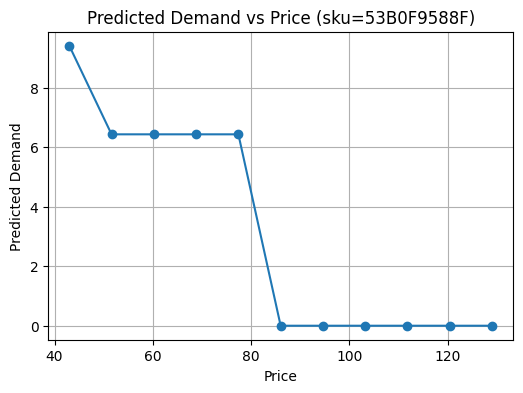

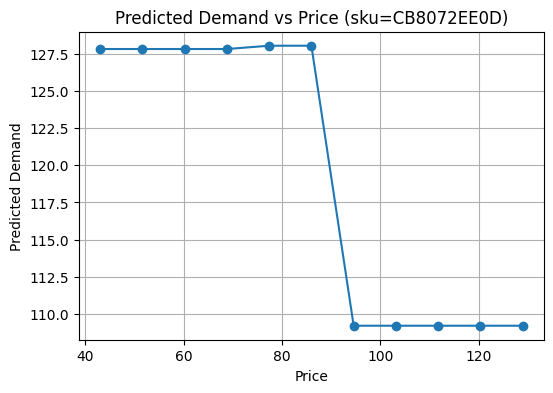

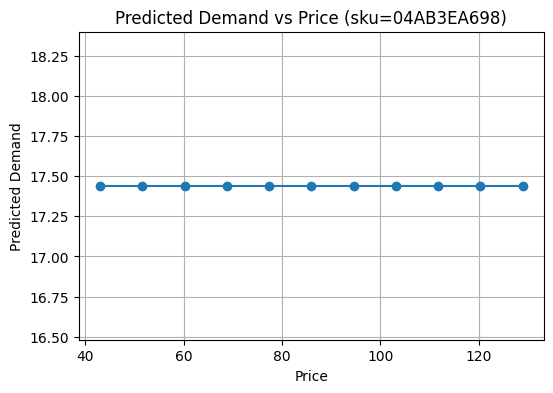

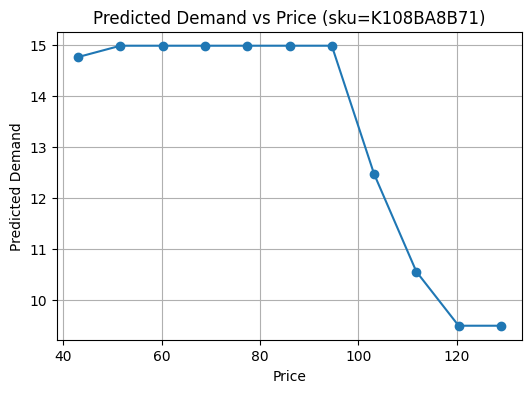

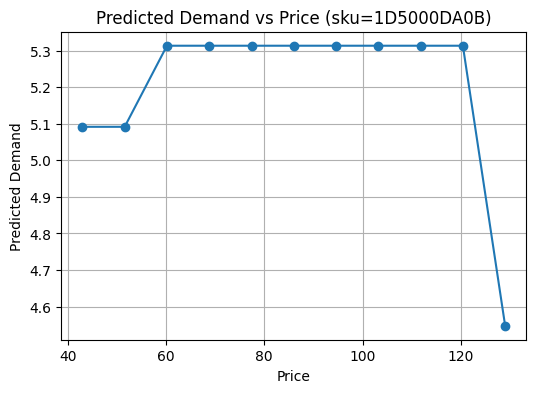

In [ ]:
# 7) EVALUATION VISUALS (Profit curves & Optimal price per scenario)
# -------------------------
# Pick random rows from test set and plot profit curves
sample_test_rows = test_df.sample(n=min(5, len(test_df)), random_state=RANDOM_SEED)
for i, rr in sample_test_rows.iterrows():
    # find a corresponding index in df (by sku_id, month_int and demand)
    cond = (df['sku_id']==rr['sku_id']) & (df['month_int']==rr['month_int']) & (df['demand']==rr['demand'])
    if cond.any():
        row_idx = df[cond].index[0]
    else:
        # fallback: use index i mapped to first matching sku
        matches = df[df['sku_id']==rr['sku_id']]
        row_idx = matches.index[0] if len(matches)>0 else 0
    profits = []
    demands = []
    for p in price_grid:
        d = predict_demand_from_features(df.iloc[row_idx], p, model, scaler, feature_cols, X_train.columns, num_cols)
        demands.append(d)
        profits.append((p - df.loc[row_idx, 'unit_cost']) * d)
    plt.figure(figsize=(6,4))
    plt.plot(price_grid, demands, marker='o')
    plt.title(f"Predicted Demand vs Price (sku={df.loc[row_idx,'sku_id']})")
    plt.xlabel("Price"); plt.ylabel("Predicted Demand"); plt.grid(True); plt.show()

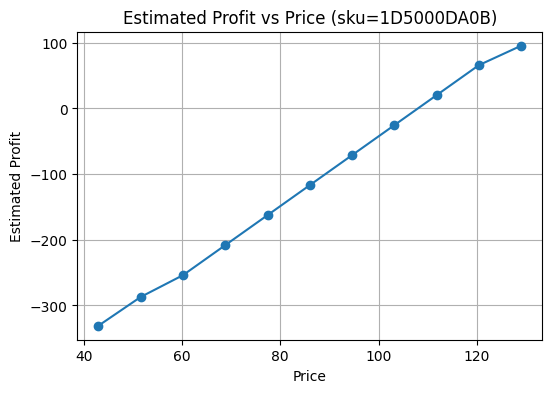

In [ ]:
    plt.figure(figsize=(6,4))
    plt.plot(price_grid, profits, marker='o')
    plt.title(f"Estimated Profit vs Price (sku={df.loc[row_idx,'sku_id']})")
    plt.xlabel("Price"); plt.ylabel("Estimated Profit"); plt.grid(True); plt.show()

In [ ]:
# Show final message and saved file paths
print("Done. Models and outputs saved to:", ARTIFACT_DIR)
print("Key files:")
for f in os.listdir(ARTIFACT_DIR):
    print(" -", f)

Done. Models and outputs saved to: /content/model_artifacts
Key files:
 - price_recommendations_by_state.csv
 - scaler.joblib
 - xgb_demand.model
 - encoders.joblib
 - q_learning.pkl
